# Introduction

Evaluation of information retrieval systems(IRS) has been actively researched for over 50 years and continues to be an area of exploration. The ability to holistically evaluate such as system is highly important for designing, developing and maintaining effective information retrieval or search systems as it allows the measurement of how successfully an information retrieval system meets its goal of helping users fulfil their information needs. Based on the need there can be many different ways that the performance of an information retrieval system can be analysed:
1. Does it retrieves relevant (compared with non-relevant) documents?
2. how quickly results are returned?
3. how well the system supports users' interactions?
4. are users are satisfied with the results?
5. how easily can users use the system?
6. does the system users carry out their tasks and fulfil their information needs? 
7. how reliable is the system? 

In this notebook, I will demo an evaluation framework that focuses on measuring how well an information retrieval system can separate relevant from non-relevant documents for a given user query. I discuss the construction of test collections and the use of standardised benchmarks for evaluating information retrieval systems. I present three empirical approaches that together provide a holistic appraisal of the performance of a Document Retrieval system that ranks documents relevant to a query document.

# Cranfield Evaluation Methodology

The Cranfield approach to information retrieval evaluation has remained popular for more than fifty years and much of this demo is based on the Cranfield Evaluation Methodology. The Cranfield experiments were computer information retrieval experiments conducted by Cyril W. Cleverdon at the College of Aeronautics at Cranfield in the 1960s, to evaluate the efficiency of indexing systems.They represent the prototypical evaluation model of information retrieval systems, and this model has been used in large-scale information retrieval evaluation efforts such as the Text Retrieval Conference (TREC). 

The main purpose of test collection experimentation for information retrieval is to develop and optimize algorithms for locating and ranking a set of documents about the same topic to a given query. The evaluation model relies on three components: 
1. a document collection (or corpus)
2. a set of queries
3. a set of relevance judgements, i.e. a file which for each query lists the documents regarded as relevant to answer the given query.

There are widely recognised weaknesses to the Cranfield approach, however in this demo I try to show it's use in establishing good heuristics even when not all the information is available.

# Quality Measures

## Ranked Relevance Quality Indictor:

i.e how well the model ranks documents based on relevance. In order to evaluate this we will be using user generated feedback. Users review query:result pairs of documents and provide three different kinds of feedback:

1. 3 star - the result is about the same same issue as the query
2. 2 star - the result is helpful in resolving the query
3. 1 star - the result is not relevant to the query

In order to evaluate a system against this feedback, we will:
1. be only using those queries which have results with more than one kind of feedback,e.g. 
   if query 1 has feedback (result 1,1 star),(result 2,3 star) then query 1 is acceptable
   if query 2 has feedback (result 1,1 star),(result 2,1 star) then query 2 is not acceptable
2. be calculating the average Normalised Discounted Cumulative Gain for each query identified in step a. 

The standard formula for nDCG is as follows:
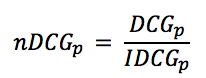
However we've found that using this formula does bad job for a dataset which has a very varied feedback distribution. To compensate for this, we will be using the following formula instead:
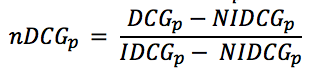
Where NIDCG or the non-ideal DCG is the exact opposite of IDCG:
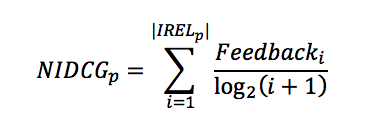

and IRELp represents the list of relevant documents (ordered in decreasing order by their feedback) in the corpus up to position p.

### Example

Assume that while user is researching relevant documents related to the query document D1, the user provides feedback for seix documents D2...D7 as shown below:

| Query | Result | Relevance Score | Feedback |Feedback Score|
|-------|--------|-----------------|----------|:------------:|
|D1|D2|0.87|3|3|
|D1|D3|0.76|2|2|
|D1|D4|0.62|3|3|
|D1|D5|0.59|1|0|
|D1|D6|0.55|1|0|
|D1|D7|0.38|2|2|

In the above table, the following should be noted:
1. Relevance Score is the score used by the information retrieval system to determine the relevance/similarity between the query and the result document. 
2. 1 star feedback is scored as 0 since that's bad feedback

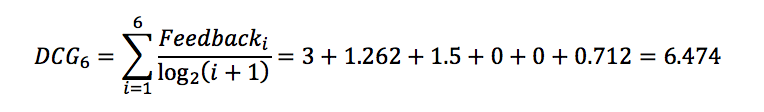

Ideal Ordering for query D1:
D2,D4,D3,D7,D5,D6

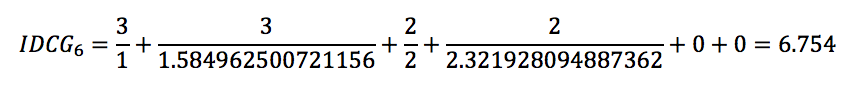

Non-Ideal Ordering for query D1:
D6,D5,D7,D3,D4,D2

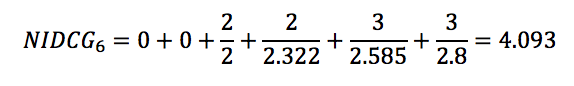

Therefor the normalised Discounted Cumulative Gain for query D1 is
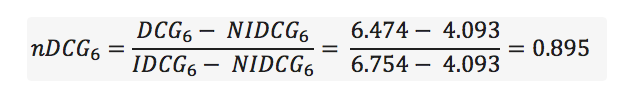

This is how the nDCG is calculated for each query for which user-provided feedback exists. The average of the scores for each query is considered the overall performance of the information retrieval system

## Semantic Relevance Quality Indicator:

i.e. how well the model is able to create semantic separation between relevant and irrelevant documents. To gauge  this we will be using a combination of metrics:
1. Cross Entropy Loss - the Cross Entropy Loss function allows us to penalise models that identify good results with a low semantic similarity and vice-versa.
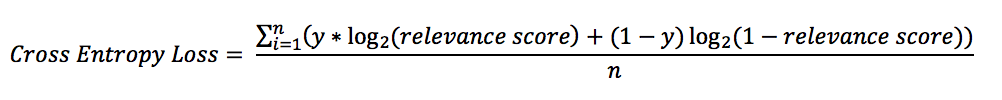
2. Semantic Quality Indicator - This metric indicates how well a model creates separation between good and bad results. To get this we identify those query:result pairs which are considered solutions and those which are not and then calculate:
    1. the delta in the average relevance score of solutions vs non-solutions - the higher this value the better the seperation between solutions and non-solutions.
    2. percentage of queries where the previous delta > 0 - ideally this should be 100%.

The same dataset used in Ranked Relevance Quality Indicator will be used for this evaluation.


### Example

Using the same sample dataset shown in the example for Ranked Relevance Quality Indicator, we can gather the following

| Q:R Pairs | Relevance Score | y(Solution or not) | Cross Entropy Loss |
| - | - | - | - |
| D1:D2 | 0.87 | 1 | log2(0.87) |
| D1:D3 | 0.76 | 1 | log2(0.76) |
| D1:D4 | 0.62 | 1 | log2(0.62) |
| D1:D7 | 0.38 | 1 | log2(0.38) |
| D1:D5 | 0.59 | 0 | log2(1 - 0.59) |
| D1:D6 | 0.55 | 0 | log2(1 - 0.55) |


    average solution relevance score = (0.87 + 0.76 + 0.62 + 0.38)/4 = 0.6575
    average non-solution relevance score = (0.59 + 0.55)/2 = 0.57
    semantic quality indicator(average) = average solution relevance score - average non-solution relevance score = 0.0875

This indicates that there isn't much semantic separation between good results(solutions) and bad results(non-solutions) and so even though the nDCG for this query was high, the low quality indictor indicates there's considerable room for improvement.

    average cross entropy loss = -log2(0.87) -log2(0.76) -log2(0.62) -log2(0.38) - log2(1-0.59) - log2(1-0.55) = 5.12073720458

A high cross entropy loss indicates that there isn't much semantic separation between good results(solutions) and bad results(non-solutions) and so even though the nDCG for this query was high, the low quality indictor indicates there's considerable room for improvement.



## Set-based Relevance Quality Indicator:

i.e standard precision and recall measures of the system. However for these metrics to be effective, we need a binary dataset consisting of queries and a list of acceptable solution. This dataset is generated using inferred references identified by domain experts which clearly indicate that a particular document should always be a part of the list of solutions for a particular query. For the purposes of this evaluation we've used bug and techzone linkage information in Service Requests. All Service Requests that are linked to bugs/techzone are identified as a potential query for this evaluation. And for each query the list of acceptable relevant documents is the list of other Service Requests(not including the query itself) that are also linked to the same bug(s)/techzone article(s). The NLP model is required to return the top 10 results for the list of queries and from this list of proposed solutions the following metrics are calculated:
1. precision
2. recall
3. F1 Measure
4. PR Curve
5. Average Precision(AUC)

### Example

For this evaluation consider the following data:

| Inferred Entity Type | Inferred Entity | Linked Documents |
| - | - | - |
| Bug | B1 | D1,D2,D3 |
| TZ Article | T1 | D3,D6,D7 |
| Bug | B2 | D2,D10,D6,D8|

So potential Query Documents here are: 

| Potential Query | Expected Results | 
| - | - | 
| D1 | D2,D3 |
| D2 | D1,D3,D10,D6,D8 |
| D3 | D1,D2,D6,D7|
| D6 | D3,D7,D2,D10,D8 |
| D7 | D3,D6 |
| D8 | D2,D10,D6 |
| D10 | D2,D6,D8 |

Assuming that NLP system returns the following top 10 results for the potential queries:

| Query | Top 10 Results | Overlap from Expected Results | P | R |
| - | - | - | - | - |
| D1 | D4,D3,D16,D2,D12,D15,D19,D8,D6,D18 | D2,D3 | 0.2 | 1.0 |
| D2 | D15,D13,D18,D14,D9,D6,D5,D10,D3,D7 | D3,D10,D6 | 0.3 | 0.6 |
| D3 | D2,D7,D30,D13,D6,D4,D9,D5,D16,D10| D2,D6,D7 | 0.3 | 0.75 |
| D6 | D14,D11,D5,D13,D9,D8,D2,D16,D1,D4 | D2,D8 | 0.2 | 0.4 |
| D7 | D20,D12,D3,D10,D9,D13,D18,D1,D16,D15 | D3 | 0.1 | 0.5 |
| D8 | D1,D15,D14,D13,D17,D9,D2,D10,D20,D7 | D2,D10 | 0.2 | 0.66 | 
| D10 | D3,D5,D9,D19,D12,D1,D14,D11,D7,D17| - | 0.0 | 0.0 |

# Building Test Collections

When constructing a test collection there are typically a number of practical issues that must be addressed (Sanderson and Braschler 2009). I’ve found that the easiest approach to solving the problem of building these test collections is:
1. crowdsourcing: the act of taking a job traditionally performed by a designated person and outsourcing to an undefined, generally large group of people in the form of an open call. Amazon Mechanical Turk (AMT) is one such example of a crowdsourcing platform. This system has around 200,000 workers from many countries that perform human intelligence tasks. Recent research has demonstrated that crowdsourcing is feasible for gathering relevance assessments (Alonso and Mizzaro 2009, Kazai 2011, Carvalho et al. 2011). 
2. inferred judgements: the internet allows for linking of content. In many cases the linkage may not be a direct implication of relevance judgement but can be used as a great substitute.

For the purpoes of this demo I will use the following data sets:

## The Ranked Relevancy Quality Indicator Evaluation Dataset 

This dataset consists of series query and result pairs:

| | query   | result  |
|-|---------|:-------:|
|0|684523967|623517439|
|1|684523967|628883675|
|2|684523967|629261277|
|3|684523967|629498957|
|4|684523967|629828141|

Here the query and result values are document IDs. Each unique query in this collection has at least 2 results with different kinds of feedback, i.e. query Q is only part of this datset if there are at least two results Rx and Ry such that the user provided feedback for Q:Rx is different from Q:Ry.

## The Ranked Relevancy Quality Indicator Model Output Dataset 

The IR system to be evaluated needs to evaluate each query result pair and update the dataset with a corredponding relevance score. This updated dataset is called the Ranked Relevancy Quality Indicator Model Output Dataset: 

| | query   | result  | score |
|-|---------|:-------:|-------|
|0|684523967|623517439|0.20858895705521474|
|1|684523967|628883675|0.35582822085889576|
|2|684523967|629261277| 0.6134969325153374|
|3|684523967|629498957| 0.656441717791411|
|4|684523967|629828141| 0.6319018404907976|

This dataset will be used to measure the Ranked Relevance Quality and the Semantic Relevance Quality of the IR system.

## The Ranked Relevancy Quality Indicator Feedback Dataset

This dataset consists of user provided relevance feedback for query-result pair that is part of the Ranked Relevancy Quality Indicator Evaluation Data Set:


| | query   | result  | feedback |
|-|---------|:-------:|----------|
|0|684523967|623517439|         1|
|1|684523967|628883675|         1|
|2|684523967|629261277|         1|
|3|684523967|629498957|         1|
|4|684523967|629828141|         1|

Feedback values are on a scale of 1 - 3:
1. The result is not relevant to the query at all
2. The result has some relevance to the query
3. The result is an exact match for the query

## Set-based Relevance Quality Indicator Evaluation Dataset

This dataset consists of a bunch of queries:

| | query | 
|-|-------|
|0|632407033|
|1|633738153|
|2|634348243|
|3|634588015|
|4|634618119|

Each query selected for this dataset must have at least 40 results that are considered relevant to the query, i.e. a query Q is only part of this dataset if there are at least 40 results Rq, such that feedback for all Q:Rq pairs is greater than 2.

## Set-based Relevance Quality Indicator Model Output Dataset

The IR system to be evaluated needs to identify the top ten relevant results for each query in the Set-Based Quality Indicator Evaluation Dataset. The resulting output needs to be updated in the Set-based Quality Indivator Model Output Dataset:

| | query | results |
|-|-------|:------:|
|0|632407033|681625716;630939469;683043174;619202453;6...|
|1|633738153|680642087;638502841;682268779;639169265;6...|
|2|634348243|680184214;637376729;637412303;680435946;6...|
|3|634588015|681317797;637351667;637749307;637414593;6...|
|4|634618119|621044225;684209635;634135015;682045177;6...|

The number of documents in the result column will always be 10.

This dataset will be used to measure the Set-based Relevance Quality of the IR system.

## Set-based Relevance Quality Indicator Feedback Dataset

This dataset consists of all results considered to be relevant each of the queries listed in the Set-based Relevance Quality Indicator Evaluation Dataset:

| | query | results |
|-|-------|:------:|
|0|632407033|633738153;634348243;634521435;634581799;6...|
|1|633738153|632407033;634348243;634521435;634581799;6...|
|2|634348243|632407033;633738153;634521435;634581799;6...|
|3|634588015|632407033;633738153;634348243;634581799;6...|
|4|634618119|632407033;633738153;634348243;634521435;6...|

In [1]:
#from pymongo import MongoClient
import warnings
import json
import pandas as pd

eval_rr_model_op = "./Model Output Datasets/ranked_relevance_quality_indicator.json" 
eval_ir_model_op = "./Model Output Datasets/set-based_relevance_quality_indicator.json" 


with open(eval_rr_model_op, encoding='utf-8') as data_file:
   data = json.loads(data_file.read())
rr_df =  pd.DataFrame(data)
rr_df.head()

,query,result,score
0,684523967,623517439,0.20858895705521474
1,684523967,628883675,0.35582822085889576
2,684523967,629261277,0.6134969325153374
3,684523967,629498957,0.656441717791411
4,684523967,629828141,0.6319018404907976


In [2]:
with open(eval_ir_model_op, encoding='utf-8') as data_file:
   data = json.loads(data_file.read())

ir_df =  pd.DataFrame(data)
ir_df.head()

,query,results
0,632407033,"[681625716, 630939469, 683043174, 619202453, 6..."
1,633738153,"[680642087, 638502841, 682268779, 639169265, 6..."
2,634348243,"[680184214, 637376729, 637412303, 680435946, 6..."
3,634588015,"[681317797, 637351667, 637749307, 637414593, 6..."
4,634618119,"[621044225, 684209635, 634135015, 682045177, 6..."


In [3]:
#Add code for evaluation here
#code should read data from NLP_EVAL_MODEL_OP and NLP_EVAL_IP to generate the results
#the results should be stored in database NLP_EVAL_RESULTS and the collection name should
# the same as in variables eval_rr_model_op and eval_ir_model_op

from operator import itemgetter
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

csv_name = f"normalized_discounted_cumulative_gain_{datetime.now().strftime('%Y-%m-%d')}.csv"
eval_rr_feedback = "./Feedback Datasets/ranked_relevance_quality_indicator.json" 
eval_ir_feedback = "./Feedback Datasets/set-based_relevance_quality_indicator.json" 

def add_feedback(df1):
    with open(eval_rr_feedback, encoding='utf-8') as data_file:
        data = json.loads(data_file.read())
        
    df2 = pd.DataFrame(data)
    df_final = pd.merge(df1, df2, how = 'inner', left_on=['query','result'], right_on=['query', 'result'])
    df_final = df_final.apply(lambda x: x.str.strip())
    df_final.score = df_final.score.apply(lambda x : float(x.replace("'","")))
    df_final.feedback = df_final.feedback.apply(lambda x : int(x.replace("'","")))
    return df_final

def retina_val(df):    
    return df[df['query'].isin([doc for doc in df['query'].unique().tolist() if len(set(df[df['query'] == doc].feedback)) != 1])]

def num_of_star(list_star):
    star_1 = 0
    star_2 = 0
    star_3 = 0
    for x in list_star:
        if x == 1:
            star_1 +=1
        elif x ==2:
            star_2 += 1
        elif x == 3:
            star_3 +=1
    return star_1, star_2, star_3

def final_eval_dataset(df_f):
    list_retina = []
    df_final = retina_val(df_f)
    for doc in df_final['query'].unique().tolist():
        dic_ret = {}
        dic_ret['query'] = doc
        len_star = len(df_final[df_final['query'] == doc].feedback.tolist())
        feedback_list = [int(x) for x in df_final[df_final['query'] == doc].feedback.tolist()]
        score_list = [float(x) for x in df_final[df_final['query'] == doc].score.tolist()]
        new_list = []
        for x, y in zip(score_list, feedback_list):
            new_list.append([x,y])
        list_cs_sorted = sorted(new_list, key=itemgetter(0), reverse=True)
        list_fb_sorted = sorted(new_list, key=itemgetter(1), reverse=True)
        list_fb_rev_sorted = sorted(new_list, key=itemgetter(1), reverse=False)
        celf = 0
        dcg = 0
        idcg = 0
        nidcg = 0
        cs_sum = 0
        for index in range(len_star):
            if list_cs_sorted[index][1] != 1:
                celf += -np.log(list_cs_sorted[index][0])
            else:
                celf += -np.log(1-list_cs_sorted[index][0])
            try:
                if list_cs_sorted[index][1] != 1:
                    dcg += list_cs_sorted[index][1]/np.math.log(index+2, 2)
                else:
                    dcg += 0
            except: 
                dcg += 0
            try:
                if list_fb_sorted[index][1] != 1:
                    idcg += list_fb_sorted[index][1]/np.math.log(index+2, 2)
                else:
                    idcg += 0
            except:
                idcg +=0
            try:
                if list_fb_rev_sorted[index][1] != 1:
                    nidcg += list_fb_rev_sorted[index][1]/np.math.log(index+2, 2)
                else:
                    nidcg += 0
            except:
                nidcg += 0
        try:
            ndcg = (dcg - nidcg)/(idcg-nidcg)
        except:
            ndcg = 'pass'
        feedbacks = num_of_star(df_final[df_final['query'] == doc].feedback.tolist())
        dic_ret['results'] = df_final[df_final['query'] == doc].result.tolist()
        dic_ret['scores'] = df_final[df_final['query'] == doc].score.tolist()
        dic_ret['feedback'] = df_final[df_final['query'] == doc].feedback.tolist()
        dic_ret['cross_entropy_loss'] = celf/len_star
        dic_ret['dcg'] = dcg
        dic_ret['ideal_dcg'] = idcg
        dic_ret['non_ideal_dcg'] = nidcg
        dic_ret['normalized_dcg'] = ndcg
        dic_ret['num_of_feedback'] = len_star
        dic_ret['3_star'] = feedbacks[2]
        dic_ret['2_star'] = feedbacks[1]
        dic_ret['1_star'] = feedbacks[0]
        list_retina.append(dic_ret)
    df = pd.DataFrame(list_retina)
    df.to_csv(csv_name, index=False)
    return df
def csv_creation_and_analysis(df_input):
    df_int = add_feedback(df_input)
    df = final_eval_dataset(df_int)
    list_temp = []
    for x, y, z,u in zip(df.scores.tolist(), df.feedback.tolist(), df.normalized_dcg.tolist(), df.cross_entropy_loss.tolist()):
        avg_cos_sim1 = []
        avg_cos_sim23 = []
        for index in range(len(y)):
            if y[index] == 1:
                avg_cos_sim1.append(x[index])
            else:
                avg_cos_sim23.append(x[index])
        list_temp.append([np.mean(avg_cos_sim1),np.mean(avg_cos_sim23), float(z), float(u)])
    df_scatter = pd.DataFrame(list_temp, columns = ['average1','average23','normalized_dcg','cross_entropy_loss'])
    df_scatter = df_scatter[pd.notnull(df_scatter.average1) & pd.notnull(df_scatter.average23)]
    df_scatter['delta'] = df_scatter.average23 - df_scatter.average1
    df_scatter['validation'] = np.where(df_scatter['delta'] > 0, True, False)
    return df.normalized_dcg, df_int, df_scatter

rr_ndcg, rr_df_int, rr_df_scatter = csv_creation_and_analysis(rr_df)

#add code to generate Inferred Relevance Quality Indictor data

def fetch_inferred_pivot_dataset():
    with open(eval_ir_feedback, encoding='utf-8') as data_file:
        data = json.loads(data_file.read())
        
    ir_mn = pd.DataFrame(data)
    return ir_mn

### Add the inferred relevance quality indicator code

def precision_recall_fpr(ir_df):
    """
    This function calculates the precision results of the each query document.
    """
    ir_mn = fetch_inferred_pivot_dataset()
    ir_df.drop_duplicates('query', keep = 'first', inplace=True)
    ir_mn.drop_duplicates('query', keep = 'first', inplace=True)
    dict_pre = {}
    dict_recall = {}
    dict_fscore = {}
    for x in ir_df['query'].unique().tolist():
        list_pre_total = []
        list_recall_total = []
        for y in ir_df[ir_df['query'] == x].results.tolist()[0]:
            count = 0
            list_pre = ir_df[ir_df['query'] == x].results.tolist()[0]
            list_recall = ir_mn[ir_mn['query'] == x].result.tolist()[0]
            for z in list_pre:
                if z in [l for l in list_recall if l != str(y)]:
                    count +=1
            list_pre_total.append(count/len(list_pre))
            list_recall_total.append(count/len(list_recall))

        precision = sum(list_pre_total)/len(list_pre_total)
        recall = sum(list_recall_total)/len(list_recall_total)
        dict_pre[x] = precision
        dict_recall[x] = recall
        try:
            dict_fscore[x] =  2*((precision * recall)/(precision + recall))
        except:
            dict_fscore[x] = 0
    ir_df['precision'] = ir_df['query'].map(dict_pre)
    ir_df['recall'] = ir_df['query'].map(dict_recall)
    ir_df['f_score'] = ir_df['query'].map(dict_fscore)
    ir_df.to_csv(f"final_precision_recall_results_{datetime.now().strftime('%Y-%m-%d')}.csv", index=False)
    return ir_df

ir_df = precision_recall_fpr(ir_df)

# Results of Evaluation

## Validation of Results

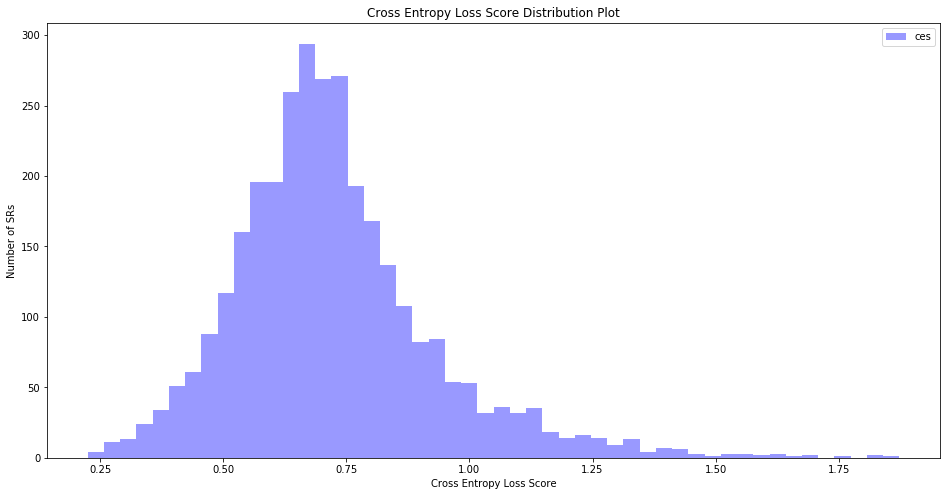

In [4]:
fig, (ax1) = plt.subplots(1, 1, sharey=True)
fig.set_size_inches(16,8)
_ = sns.distplot(rr_df_scatter.cross_entropy_loss, color = 'blue', label= ['ces'], kde=False, norm_hist = False, ax =ax1)
#_ = sns.distplot(df_int[(df_int.feedback == 2) | (df_int.feedback == 3)].score, color = 'red', label= ['2 & 3 stars'], kde=False, norm_hist = False, ax =ax1)
_ = ax1.set_xlabel('Cross Entropy Loss Score')
_ = ax1.set_ylabel('Number of SRs')
_ = ax1.set_title ('Cross Entropy Loss Score Distribution Plot')
_ = ax1.legend(loc='upper right')
plt.show()

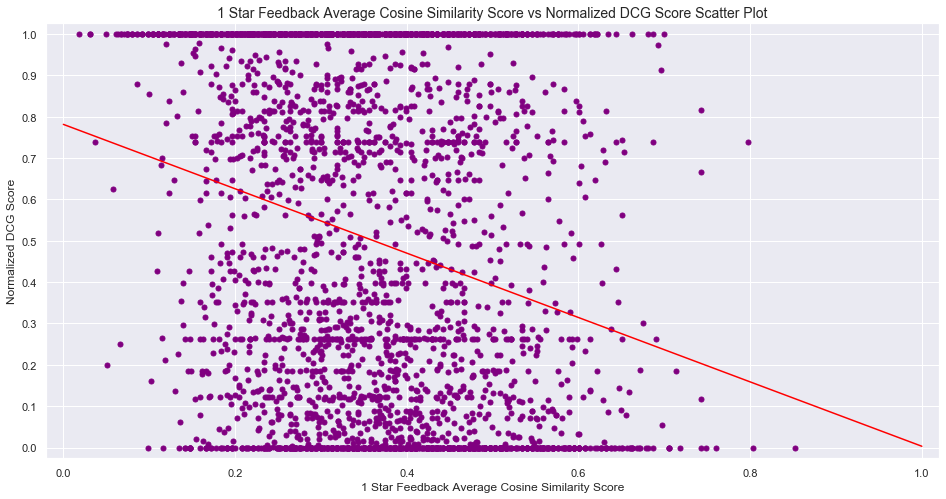

In [5]:
sns.set()
plt.figure(figsize = (16,8))
_ = plt.scatter(rr_df_scatter.average1, rr_df_scatter.normalized_dcg, color = 'purple', s = 100, marker = '.', norm = True)
x_max, y_max = np.polyfit(rr_df_scatter.average1, rr_df_scatter.normalized_dcg, 1)
x = np.array([0,1])
y_mx = x_max * x + y_max
# Add regression line to your plot
_ = plt.plot(x, y_mx, color='red')
_ = plt.xlabel('1 Star Feedback Average Cosine Similarity Score')
_ = plt.yticks(ticks=[0.1,0.2,0.3,0.4,0,.5,0.6,0.7,0.8,0.9,1.0])
_ = plt.ylabel('Normalized DCG Score')
#_ = plt.legend(loc='upper right')
_ = plt.title('1 Star Feedback Average Cosine Similarity Score vs Normalized DCG Score Scatter Plot', size = 14)
plt.margins(0.02)

<b>Inference : As the average relevance score of 1 star results for a particular query increases the nDCG score for that query goes down</b>

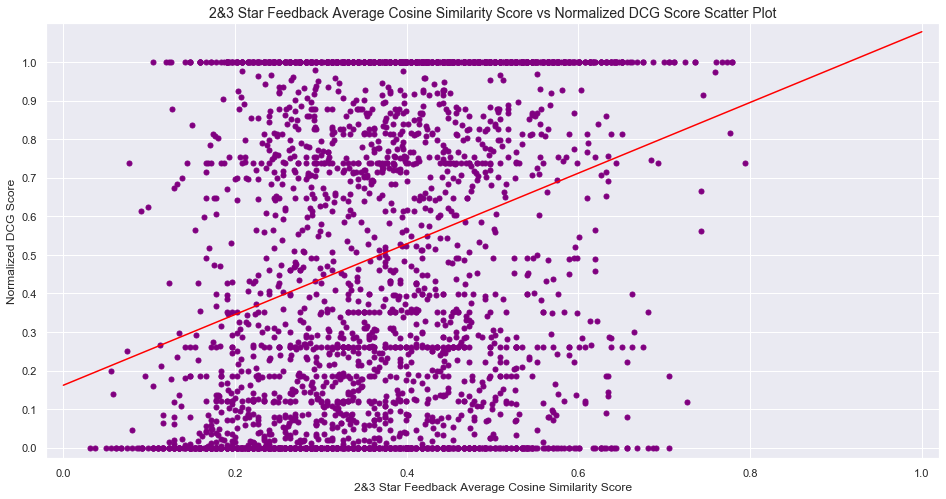

In [6]:
plt.figure(figsize = (16,8))
_ = plt.scatter(rr_df_scatter.average23, rr_df_scatter.normalized_dcg, color = 'purple', s = 100, marker = '.', norm = True)
x_max, y_max = np.polyfit(rr_df_scatter.average23, rr_df_scatter.normalized_dcg, 1)
x = np.array([0,1])
y_mx = x_max * x + y_max
# Add regression line to your plot
_ = plt.plot(x, y_mx, color='red')
_ = plt.xlabel('2&3 Star Feedback Average Cosine Similarity Score')
_ = plt.yticks(ticks=[0.1,0.2,0.3,0.4,0,.5,0.6,0.7,0.8,0.9,1.0])
_ = plt.ylabel('Normalized DCG Score')
#_ = plt.legend(loc='upper right')
_ = plt.title('2&3 Star Feedback Average Cosine Similarity Score vs Normalized DCG Score Scatter Plot', size = 14)
plt.margins(0.02)

<b>Inference : As the average relevance score of 2/3 star results for a particular query increases the nDCG score for that query goes up</b>

If the nDCG score is doing a good job of approximating the quality of results returned then the intercept in the first graph will slant sharply downwards to the right and in the second graph it will slant sharply upwards to the right.

## Ranked Relevance Quality Indicator

In [ ]:
print ('Average Normalized Decreased Cumulative Gain: ', round(np.mean(rr_ndcg),3))

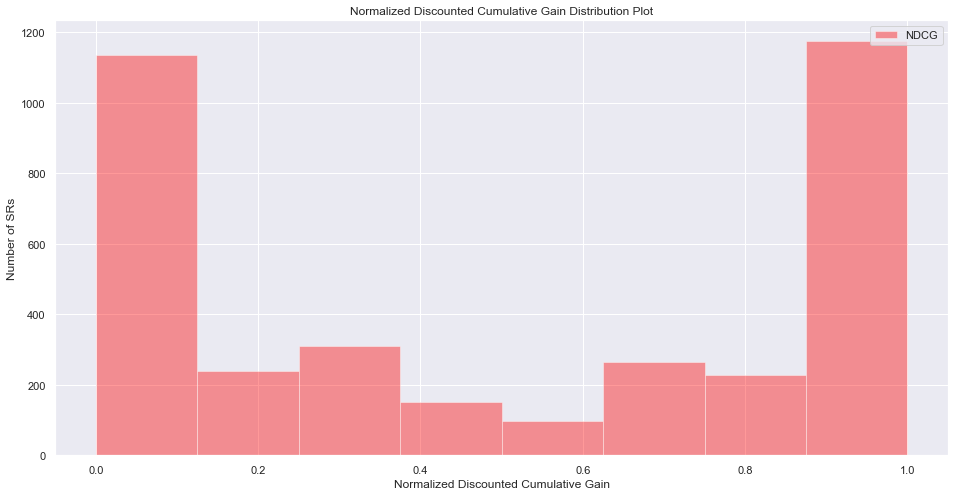

In [7]:
fig, (ax1) = plt.subplots(1, 1, sharey=True)
fig.set_size_inches(16, 8)
_ = sns.distplot(rr_ndcg, color = 'red', label= ['NDCG'], kde=False, norm_hist = False, ax =ax1)
_ = ax1.set_xlabel('Normalized Discounted Cumulative Gain')
_ = ax1.set_ylabel('Number of SRs')
_ = ax1.set_title ('Normalized Discounted Cumulative Gain Distribution Plot')
_ = ax1.legend(loc='upper right')
plt.show()

In an ideal situation, the graph should have an increasing number of queries with a high normalised Discounted Cumulative Gain. 

## Semantic Relevance Quality Indicator

In [8]:
print ('Cross_Entropy_Loss_Function Score(average): ', round(np.mean(rr_df_scatter.cross_entropy_loss),3))
print ('Relevance Quality Indicator (percentage): ', round(rr_df_scatter[rr_df_scatter.validation == True].__len__()/len(rr_df_scatter)*100,2))
print ('Relevance Quality Indicator (average): ', round(np.mean(rr_df_scatter.delta),3))

Cross_Entropy_Loss_Function Score(average):  0.723
Relevance Quality Indicator (percentage):  55.37
Relevance Quality Indicator (average):  0.009


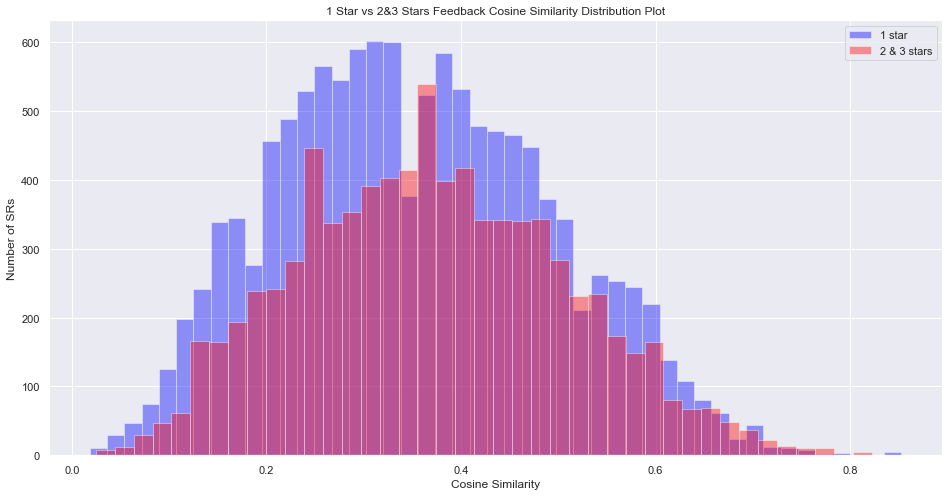

In [9]:
fig, (ax1) = plt.subplots(1, 1, sharey=True)
fig.set_size_inches(16, 8)
_ = sns.distplot(rr_df_int[rr_df_int.feedback == 1].score, color = 'blue', label= ['1 star'], kde=False, norm_hist = False, ax =ax1)
_ = sns.distplot(rr_df_int[(rr_df_int.feedback == 2) | (rr_df_int.feedback == 3)].score, color = 'red', label= ['2 & 3 stars'], kde=False, norm_hist = False, ax =ax1)
_ = ax1.set_xlabel('Cosine Similarity')
_ = ax1.set_ylabel('Number of SRs')
_ = ax1.set_title ('1 Star vs 2&3 Stars Feedback Cosine Similarity Distribution Plot')
_ = ax1.legend(loc='upper right')
plt.show()

A retrieval system that is doing a good job should show significant sepration between the distribution of the average relevance scores of solutions and non-solutions.

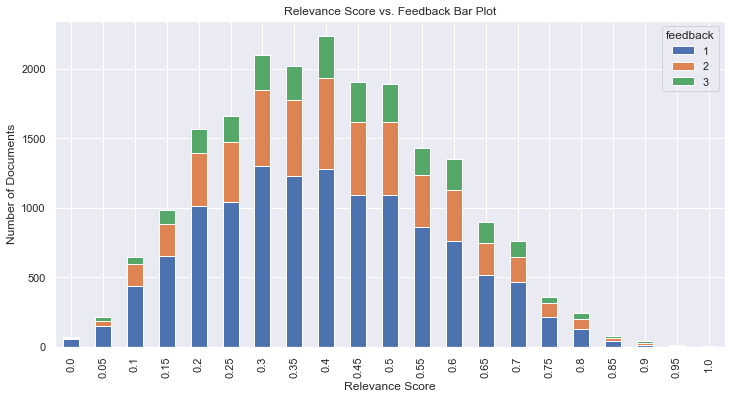

In [10]:
rr_df_int['interval'] = pd.cut(rr_df_int.score, 21, labels=[str(round(x,2)) for x in np.arange(0,1.05,0.05)])
df2 = rr_df_int.groupby(['interval', 'feedback'])['interval'].count().unstack('feedback')
df2.plot(kind='bar', figsize= (12,6), stacked=True, title='Relevance Score vs. Feedback Bar Plot')
plt.ylabel('Number of Documents')
plt.xlabel('Relevance Score')
plt.show()

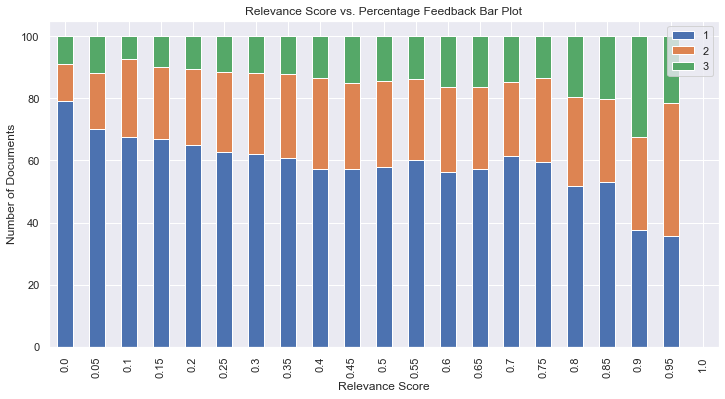

In [11]:
df2 = df2.reset_index().set_index('interval')
df2.columns = ['1_star','2_star','3_star']
df2['1'] = (df2['1_star'] / (df2['1_star'] + df2['2_star'] + df2['3_star']))*100
df2['2'] = (df2['2_star'] / (df2['1_star'] + df2['2_star'] + df2['3_star']))*100
df2['3'] = (df2['3_star'] / (df2['1_star'] + df2['2_star'] + df2['3_star']))*100
df2[['1','2','3']].plot(kind='bar', figsize= (12,6), stacked=True, title='Relevance Score vs. Percentage Feedback Bar Plot')
plt.ylabel('Number of Documents')
plt.xlabel('Relevance Score')
plt.show()

A good NLP system should show a steadily decreasing proportion of blue in the stacked bars as the relevance score increases. There should be close to 0 1 star results that have such a high similarity score.

## Inferred Relevance Quality Indicator

In [12]:
print ('Average Precision Score: ', round(np.mean(ir_df.precision),3))
print ('Average Recall Score: ', round(np.mean(ir_df.recall),3))
print ('Average F Score: ', round(np.mean(ir_df.f_score),3))
area = metrics.auc(sorted(ir_df.recall, reverse=True), sorted(ir_df.precision, reverse=True))
print('Precision Recall Area Under Curve:', area)

Average Precision Score:  0.121
Average Recall Score:  0.009
Average F Score:  0.016
Precision Recall Area Under Curve: 0.10310705631336159


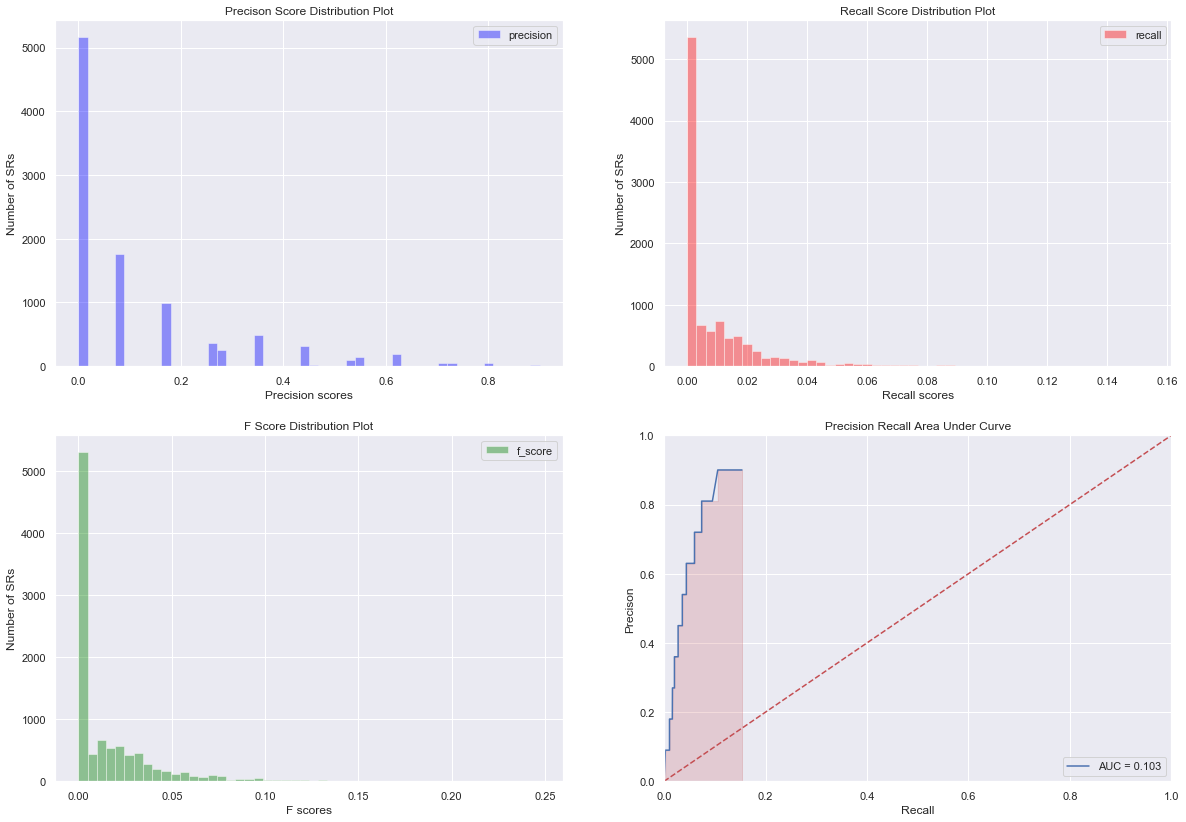

In [13]:
sns.set()
fig = plt.figure(figsize=(20, 14))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1 = sns.distplot(ir_df.precision, color = 'blue', label= ['precision'], kde=False, norm_hist = False)
ax1 = plt.xlabel("Precision scores")
ax1 = plt.ylabel("Number of SRs")
ax1 = plt.title("Precison Score Distribution Plot")
ax1 = plt.legend(loc='upper right')

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2 = sns.distplot(ir_df.recall, color = 'red', label= ['recall'], kde=False, norm_hist = False)
ax2 = plt.xlabel("Recall scores")
ax2 = plt.ylabel("Number of SRs")
ax2 = plt.title("Recall Score Distribution Plot")
ax2 = plt.legend(loc='upper right')


ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3 = sns.distplot(ir_df.f_score, color = 'green', label= ['f_score'], kde=False, norm_hist = False)
ax3 = plt.xlabel("F scores")
ax3 = plt.ylabel("Number of SRs")
ax3 = plt.title("F Score Distribution Plot")
ax3 = plt.legend(loc='upper right')


ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4 = plt.title('Precision Recall Area Under Curve')
ax4 = plt.plot(sorted(ir_df.recall, reverse=False), sorted(ir_df.precision, reverse=False), 'b', label = 'AUC = %0.3f' % area)
ax4 = plt.fill_between(sorted(ir_df.recall, reverse=False), sorted(ir_df.precision, reverse=False), step='post', alpha=0.2, color='r')
ax4 = plt.legend(loc = 'lower right')
ax4 = plt.plot([0, 1], [0, 1],'r--')
ax4 = plt.xlim([0, 1])
ax4 = plt.ylim([0, 1])
ax4 = plt.ylabel('Precison')
ax4 = plt.xlabel('Recall')